In [1]:
from kendall.main import SISOStream

In [2]:
import numpy.random
from kendall import Simulator, Entity, Stream, ExponentialSpawner, Queue, RandomSplitter, Worker, Merger, Dropper


def average(list):
    return sum(list) / float(len(list))

def debug_entities(entity_list):
    print "Entity list: ", len(entity_list)
    for e in entity_list[:10]:
        print e.id
        for evt in e.event_list:
            if evt[2] == "queue":
                print evt
        # print e.event_table

def time_between_events(entity_list, event1, event2):
    times = []
    for e in entity_list:
        if e.event_table.get(event1) and e.event_table.get(event2):
            time = e.event_table.get(event2) - e.event_table.get(event1)
            times.append(time)
    return times

class CraneWorker(Worker):
    def time_to_finish(self, entity, time):
        return numpy.random.uniform(0.5, 1.5)

    
class ShipSpawner(ExponentialSpawner):
    last_created = 0
    spawn_delays = []

    def start(self):
        super(ShipSpawner, self).start()
        ShipSpawner.last_created = 0
        ShipSpawner.spawn_delays = []

    def create_entity(self, time):
        ShipSpawner.spawn_delays.append(time - ShipSpawner.last_created)
        ShipSpawner.last_created = time
        return Entity()
    
class HarborSimulator(Simulator):
    all_counts = []
    all_spawn_delays = []
    all_processing_times = []
    all_minimums = []
    all_averages = []
    all_maximums = []
    all_cranes = [[], []]
    all_delays = []
    all_stuck = []

    def __init__(self, *args, **kwargs):
        super(HarborSimulator, self).__init__(*args, **kwargs)
        Stream.simulator = self
        self.create_streams()

    def create_streams(self):
        self.spawner = ShipSpawner(name="spawner", spawn_time=1.25)
        self.queue = Queue(name="queue")
        self.crane_assigner = RandomSplitter(name="splitter")
        self.craneA = CraneWorker(name="craneA")
        self.craneB = CraneWorker(name="craneB")
        self.merger = Merger(name="merger")
        self.dropper = Dropper(name="dropper")
        self.spawner.pipe(self.queue)
        self.queue.pipe(self.crane_assigner)
        self.crane_assigner.pipe(self.craneA)
        self.crane_assigner.pipe(self.craneB)
        self.craneA.pipe(self.merger)
        self.craneB.pipe(self.merger)
        self.merger.pipe(self.dropper)

    def reset(self):
        super(HarborSimulator, self).reset()
        Entity.id = 0

    def analyze(self):
        # debug_entities(self.entity_list)
        # return
        def times_in_harbor(entity_list):
            return time_between_events(entity_list, ("spawner", "exit"), ("dropper", "enter"))

        def times_in_crane(entity_list):
            return time_between_events(entity_list, ("splitter", "exit"), ("merger", "enter"))

        def crane_times(entity_list, crane):
            return time_between_events(entity_list, (crane, "enter"), (crane, "exit"))

        def finishing_times(entity_list, crane):
            times = []
            for e in entity_list:
                if e.event_table.get("dropper", "enter"):
                    times.append(e.event_table.get("dropper", "enter"))
            return times

        waiting_times = times_in_harbor(self.entity_list)
        processing_times = times_in_crane(self.entity_list)

        minimum = min(waiting_times)
        average = sum(waiting_times) / len(waiting_times)
        maximum = max(waiting_times)

        # print "Minimum:", minimum
        # print "Average:", average
        # print "Maximum:", maximum
        for num, crane in [(0, 'craneA'), (1, 'craneB')]:
            times = crane_times(self.entity_list, crane)
            total_time = sum(times)
            util = total_time / 100.00
            # print "Utilization of Crane {}: {}".format(crane, util)
            HarborSimulator.all_cranes[num].append(util)
        delay = len([x for x in waiting_times if x >= 2.00]) / float(len(waiting_times))
        # print "Percent over 2 days:", delay
        HarborSimulator.all_counts.append(len(self.entity_list))
        HarborSimulator.all_spawn_delays.extend(ShipSpawner.spawn_delays)
        HarborSimulator.all_processing_times.extend(processing_times)
        HarborSimulator.all_stuck.append(len(self.entity_list) - len(waiting_times))
        HarborSimulator.all_minimums.append(minimum)
        HarborSimulator.all_maximums.append(maximum)
        HarborSimulator.all_averages.append(average)
        HarborSimulator.all_delays.append(delay)

sim = HarborSimulator(time_limit=100)
for x in xrange(1, 1000):
    processing_times = []
    sim.reset()
    sim.run()
    sim.analyze()


In [3]:
import matplotlib.pyplot as plt

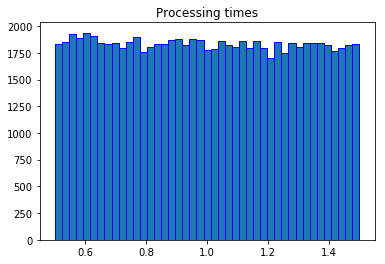

Average processing time: 0.996794890508


In [4]:
plt.hist(HarborSimulator.all_processing_times, bins='auto', edgecolor="blue")
plt.title("Processing times")
plt.show()

print "Average processing time:", average(HarborSimulator.all_processing_times)

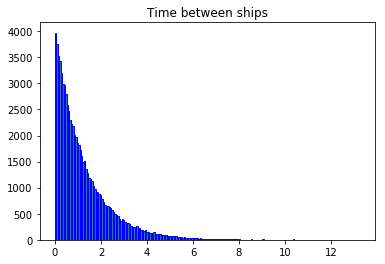

Average time between ships: 1.23817279295


In [5]:
plt.hist(HarborSimulator.all_spawn_delays, bins='auto', edgecolor="blue")
plt.title("Time between ships")
plt.show()

print "Average time between ships:", average(HarborSimulator.all_spawn_delays)

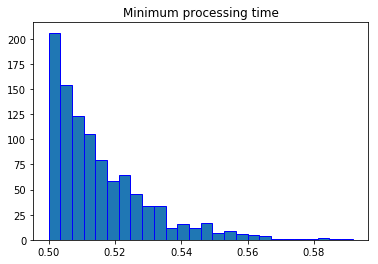

Average Minimum: 0.515572650564


In [6]:
plt.hist(HarborSimulator.all_minimums, bins='auto', edgecolor="blue")
plt.title("Minimum processing time")
plt.show()

print "Average Minimum:", average(HarborSimulator.all_minimums)

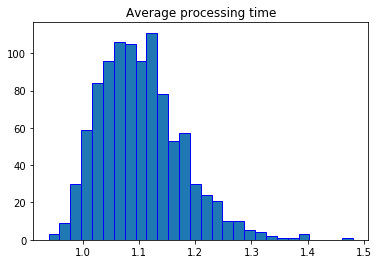

Mean Average: 1.10329607734


In [7]:
plt.hist(HarborSimulator.all_averages, bins='auto', edgecolor="blue")
plt.title("Average processing time")
plt.show()

print "Mean Average:", average(HarborSimulator.all_averages)

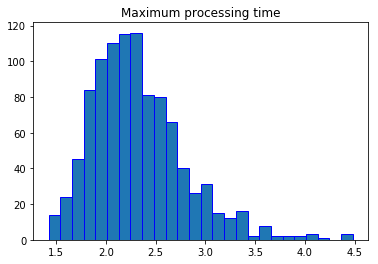

Mean Maximum: 2.31927256091


In [8]:
plt.hist(HarborSimulator.all_maximums, bins='auto', edgecolor="blue")
plt.title("Maximum processing time")
plt.show()

print "Mean Maximum:", average(HarborSimulator.all_maximums)

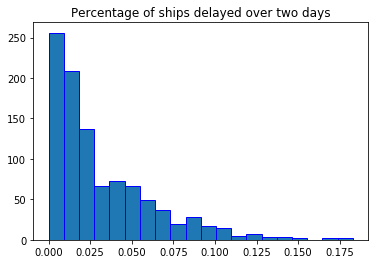

Mean Percentage Delayed: 0.030606209368


In [9]:
plt.hist(HarborSimulator.all_delays, bins='auto', edgecolor="blue")
plt.title("Percentage of ships delayed over two days")
plt.show()

print "Mean Percentage Delayed:", average(HarborSimulator.all_delays)

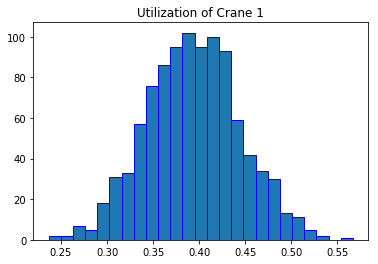

Mean Utilization of Crane 1: 0.393305555736


In [10]:
plt.hist(HarborSimulator.all_cranes[0], bins='auto', edgecolor="blue")
plt.title("Utilization of Crane 1")
plt.show()

print "Mean Utilization of Crane 1:", average(HarborSimulator.all_cranes[0])


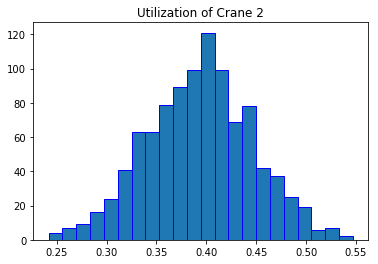

Mean Utilization of Crane 2: 0.393184570936


In [11]:
plt.hist(HarborSimulator.all_cranes[1], bins='auto', edgecolor="blue")
plt.title("Utilization of Crane 2")
plt.show()

print "Mean Utilization of Crane 2:", average(HarborSimulator.all_cranes[1])

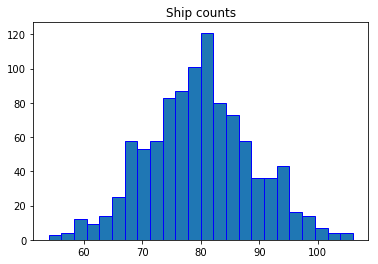

Mean ship counts: 79.7727727728


In [12]:
plt.hist(HarborSimulator.all_counts, bins='auto', edgecolor="blue")
plt.title("Ship counts")
plt.show()

print "Mean ship counts:", average(HarborSimulator.all_counts)

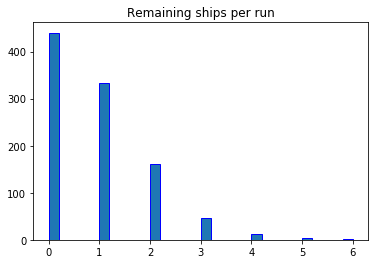

Mean Remaining ships: 0.870870870871


In [13]:
plt.hist(HarborSimulator.all_stuck, bins='auto', edgecolor="blue")
plt.title("Remaining ships per run")
plt.show()

print "Mean Remaining ships:", average(HarborSimulator.all_stuck)